In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

In [2]:
print('CPU: {}'.format(len(tf.config.list_physical_devices('CPU'))))
print('GPU: {}'.format(len(tf.config.list_physical_devices('GPU'))))

CPU: 1
GPU: 1


In [3]:
data = pd.read_csv('fer/fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
# shape of the dataframe loaded

data.shape

(35887, 3)

In [5]:
# basic analysis

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [6]:
# checking the values for understanding of usage

for i in ['emotion', 'Usage']:
    print(data[i].unique())

[0 2 4 6 3 5 1]
['Training' 'PublicTest' 'PrivateTest']


In [7]:
# calculate the image size

math.sqrt(len(data.pixels[0].split(' ')))

48.0

In [8]:
# chaning the pixels to numpy array

X = data['pixels'].apply(lambda x: np.array(x.split()).reshape(48, 48, 1).astype('float32'))
X = np.stack(X, axis=0)
X.shape

(35887, 48, 48, 1)

In [9]:
# extracting y label and declaring the emotions

lookup = ('anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral')
y = data['emotion']
y.shape

(35887,)

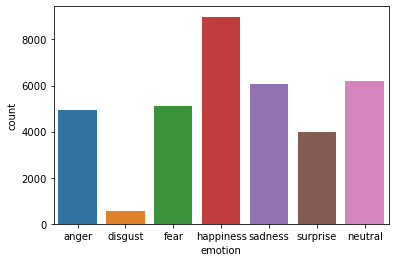

In [10]:
# Count of photo with respect to different emotions

sns.countplot(x=y)
plt.xticks(range(7), lookup);

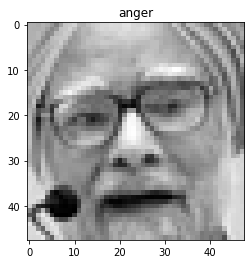

In [11]:
# examine the images

def plot_index(index):
    plt.imshow(X[index].reshape((48,48)), cmap='gray')
    plt.title(lookup[y[index]])

index = int(input('Enter Value: '))
plot_index(index)

Feature Engineering

In [12]:
# Label encoding

le = LabelEncoder()
img_labels = le.fit_transform(y)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [13]:
# dividing the image value by 255.0 so that all values can be filled between 0.0 and 1.0

print('Before Transformation', np.max(X))
X = X / 255.0
print('After Transformation', np.max(X))

Before Transformation 255.0
After Transformation 1.0


In [14]:
# splitting the dataset into training and testing sets

X_train, X_valid, y_train, y_valid = train_test_split(X, img_labels, test_size=0.1, stratify=img_labels)
print('Shape of training set', y_train.shape[0])
print('Shape of validation set', y_valid.shape[0])

Shape of training set 32298
Shape of validation set 3589


Creating and training the model

In [15]:
# creating model of convolutional neural network

model = Sequential()

model.add(
    Conv2D(
        filters = 64,
        kernel_size = (5, 5),
        input_shape = (48, 48, 1),
        activation = 'elu',
        padding = 'same',
        kernel_initializer = 'he_normal'
    )
)
model.add(BatchNormalization())

model.add(
    Conv2D(
        filters = 64,
        kernel_size = (5, 5),
        activation = 'elu',
        padding = 'same',
        kernel_initializer = 'he_normal'
    )
)
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.4))

model.add(
    Conv2D(
        filters = 128,
        kernel_size = (3, 3),
        activation = 'elu',
        padding = 'same',
        kernel_initializer = 'he_normal'
    )
)
model.add(BatchNormalization())

model.add(
    Conv2D(
        filters = 128,
        kernel_size = (3, 3),
        activation = 'elu',
        padding = 'same',
        kernel_initializer = 'he_normal'
    )
)
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.4))

model.add(
    Conv2D(
        filters = 256,
        kernel_size = (3, 3),
        activation = 'elu',
        padding = 'same',
        kernel_initializer = 'he_normal'
    )
)
model.add(BatchNormalization())

model.add(
    Conv2D(
        filters = 256,
        kernel_size = (3, 3),
        activation = 'elu',
        padding = 'same',
        kernel_initializer = 'he_normal'
    )
)
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.4))

model.add(Flatten(name='flatten'))
        
model.add(
    Dense(
        128,
        activation='elu',
        kernel_initializer='he_normal',
    )
)
model.add(BatchNormalization())
    
model.add(Dropout(0.6))
    
model.add(
    Dense(
        7,
        activation='softmax'
    )
)

In [16]:
# checking the summary of the model

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

In [17]:
# compile the model

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [18]:
# function for early stopping in when change in accuracy is low and ReduceLROnPlateau for learning rate

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [19]:
# creating images for increasing data

gen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    shear_range = 0.15,
    zoom_range = 0.15,
    horizontal_flip = True
)
gen.fit(X_train)

In [20]:
# training the model

model.fit(
    gen.flow(X_train, y_train, batch_size=32),
    validation_data = (X_valid, y_valid),
    steps_per_epoch = len(X_train) / 32,
    epochs = 100,
    callbacks = callbacks,
    use_multiprocessing = True
)

Epoch 1/100


Exception in thread Thread-3 (_run):
Traceback (most recent call last):
  File "c:\Users\aakas\anaconda3\envs\emotion\lib\threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "c:\Users\aakas\anaconda3\envs\emotion\lib\threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\aakas\anaconda3\envs\emotion\lib\site-packages\keras\utils\data_utils.py", line 745, in _run
    with closing(self.executor_fn(_SHARED_SEQUENCES)) as executor:
  File "c:\Users\aakas\anaconda3\envs\emotion\lib\site-packages\keras\utils\data_utils.py", line 722, in pool_fn
    pool = get_pool_class(True)(
  File "c:\Users\aakas\anaconda3\envs\emotion\lib\multiprocessing\context.py", line 119, in Pool
    return Pool(processes, initializer, initargs, maxtasksperchild,
  File "c:\Users\aakas\anaconda3\envs\emotion\lib\multiprocessing\pool.py", line 212, in __init__
    self._repopulate_pool()
  File "c:\Users\aakas\anaconda3\envs\emotion\lib\multiprocessing\pool.py",